#########################################################################
 MoRed - GeM Laboratory
 ECOLE CENTRALE DE NANTES
#########################################################################

In [ ]:
import os
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

### Exact Solution

Exact Solution of Transient Heat Equation in Exercise 3

In [ ]:
def ExactSolution(x,t,N):
    k = 1
    X = np.zeros([x.size,N])
    T = np.zeros([t.size,N])
    L = x[-1]-x[0]
    n = np.arange(1,2*(N-1),2)
    X = np.sin(np.pi*np.outer(n, x)/L)
    T = np.exp(-k*np.pi**2*np.outer(n**2, t)/L**2)
    A = -4*L**3/(k*np.pi**3)/(n**3)
    U = (X*np.atleast_2d(A).T).T@T +  np.outer((x*(L-x))/2/k, np.ones(t.size))
    # U = np.outer((x*(L-x))/2/k, np.ones(t.size))
    return U

### PGD solution

 PGD solution of the transient heat equation with homogeneous Dirichlet boundary conditions and homogeneous initial condition

In [ ]:
def HT1D_PGD_XT(x,t,k,rho,cp,Max_terms,Max_fp_iter,epsilon,epsilon_tilde,f0,f1):
    '''PGD space time separation for transient heat problem on 1D uniform discretization'''

    ## Mesh definition for each dimension
    Nt = t.size
    Nx = x.size
    ## Mesh size
    dt = t[1]-t[0]
    hx = x[1]-x[0]

    ## Finite difference matrices in x
    Ix = rho*cp*sparse.eye(Nx)   
    ## Finite difference second order differentiation matrix
    Kx = (k/hx**2)*sparse.spdiags(np.vstack([np.ones(Nx), -2*np.ones(Nx), np.ones(Nx)]),[-1, 0, 1],(Nx,Nx))

    ## Finite difference matrices in time
    It =  sparse.eye(Nt)                                                                 
    ## Time differentiation matrix
    Gt = (1/dt) * sparse.spdiags([1*np.ones(Nt),-1*np.ones(Nt)], [0, -1], Nt, Nt)         

    ## Containers to store the B1s and B2s functions
    alpha = []
    B0s = np.zeros((Nx, 0))
    B1s = np.zeros((Nt, 0))

    ## Enrichment loop
    for term in range(Max_terms):
        ## Initialization of the fixed point loop
        B0 = np.ones(Nx)
        B1 = np.ones(Nt)

        ## Satisfaction of the homogeneous Dirichlet Boundary conditions & Initial Condtions for the enrichments. 
        B0[0] = 0.           
        B0[-1] = 0.          
        B1[0] = 0.

        ## Fixed point iterations
        for i in range(Max_fp_iter):
            ## Store the old values of B0 & B1 for later comparison
            ## To create a copy of array x, we use the syntax y = x.copy(), rather than just y=x (MATLAB style)
            B0_Old = B0.copy()
            B1_Old = B1.copy()

            ## Solve for B0
            ## Construction of the boundary value problem along x

            ## LHS coefficients
            alpha_0  = np.trapz(((Gt@B1)*B1), x=t)
            beta_0 = np.trapz((B1*B1), x=t)

            ## Construction of LHS operator
            A0 = alpha_0*(Ix) - beta_0*(Kx) 

            ## Source term coefficient
            gamma_0 = np.trapz(B1*f1, x = t)
            ## Construction of the RHS
            b0 = gamma_0*f0
            ## In case this is not the first enrichment, previous terms are added to the RHS
            if term>0:
                ## RHS coefficients
                alpha_0_i = np.trapz(np.multiply(B1, (Gt@B1s).T), x=t) 
                beta_0_i = np.trapz(np.multiply(B1, B1s.T), x=t) 
                b0 = b0 - (Ix@B0s)@(alpha_0_i*alpha).T + (Kx@B0s)@(beta_0_i*alpha).T  

            ## Solution with homogeneous boundary conditions
            B0[1:-1] = sparse.linalg.spsolve(A0[1:-1,1:-1], b0[1:-1])

            ## Solve for B1
            ## Construction of the initial value problem along t
            
            ## LHS coefficients
            alpha_1 = np.trapz((B0*B0), x=x)      
            beta_1  = np.trapz((Kx@B0)*B0, x=x)  

            ## Construction of LHS operator
            A1 = alpha_1*(Gt) - beta_1*(It)          

            ## Source term coefficient
            gamma_1 = np.trapz(B0*f0, x = x) 

            ## Construction of the RHS
            b1 = gamma_1*f1
            ## In case this is not the first enrichment, previous terms are added to the RHS
            if term>0:
                ## RHS coefficients
                alpha_1_i = np.trapz(np.multiply(B0, B0s.T), x=x)                       
                beta_1_i = np.trapz(np.multiply(B0, (Kx@B0s).T), x=x)                   
                b1 = b1 + (It@B1s)@(beta_1_i*alpha).T - (Gt@B1s)@(alpha_1_i*alpha).T    

            ## Solution with homogeneous initial condition.
            B1[1:-1] = sparse.linalg.spsolve(A1[1:-1,1:-1], b1[1:-1])

            ## Norm of the difference between the 2 fixed point iterations
            S_difference = np.sqrt(np.trapz(B0**2, x=x)*np.trapz(B1*B1, x=t) + np.trapz(B0_Old**2,x=x)*np.trapz(B1_Old**2,x=t) - 2*np.trapz(B0*B0_Old,x=x)*np.trapz(B1*B1_Old,x=t))
            ## Fixed point exit test
            if S_difference < epsilon:
                break
        ## Normalized modes are added to the  existing ones
        fact_0 = np.linalg.norm(B0) 
        fact_1 = np.linalg.norm(B1) 
        alpha = np.concatenate((alpha, [fact_0*fact_1]))
        B0s = np.column_stack((B0s, B0/fact_0))
        B1s = np.column_stack((B1s, B1/fact_1))

        ## Simplified stopping criterion
        E = alpha[term] / alpha[0]
        if E<epsilon_tilde:
            break
    return alpha,B0s,B1s

### Script

Script to compare the solutions

/tmp/ipykernel_87/1362144783.py:39: RuntimeWarning: divide by zero encountered in divide
  Relative_Error = abs(PGD_Solution - U)/abs(PGD_Solution)
/tmp/ipykernel_87/1362144783.py:39: RuntimeWarning: invalid value encountered in divide
  Relative_Error = abs(PGD_Solution - U)/abs(PGD_Solution)


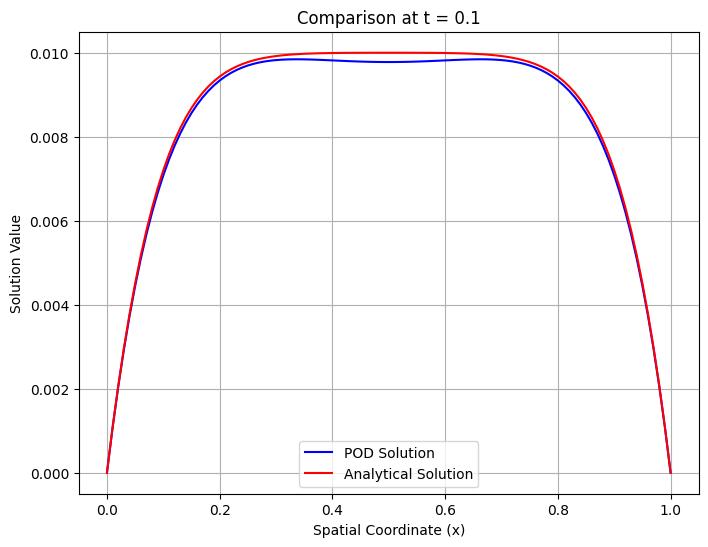

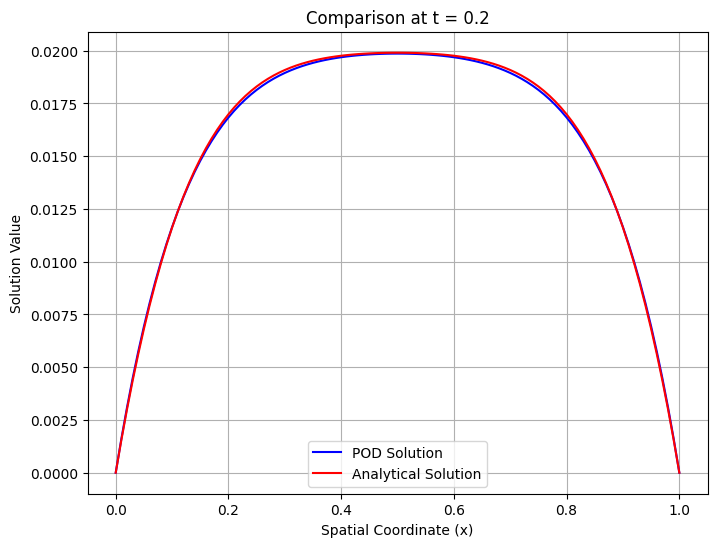

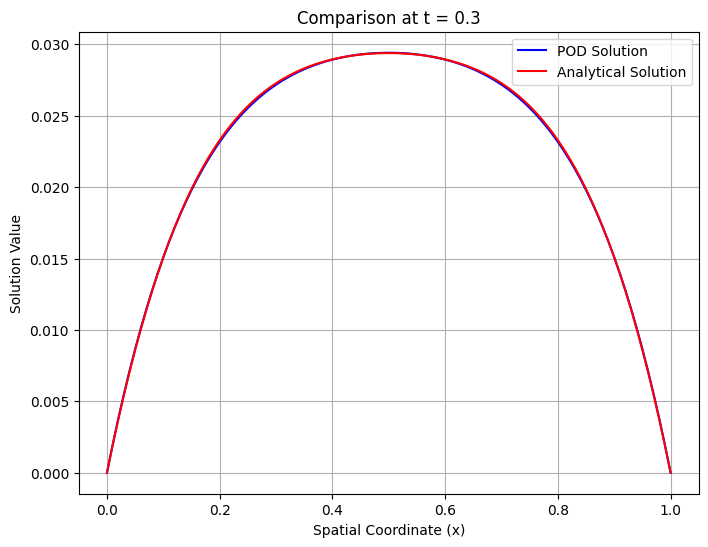

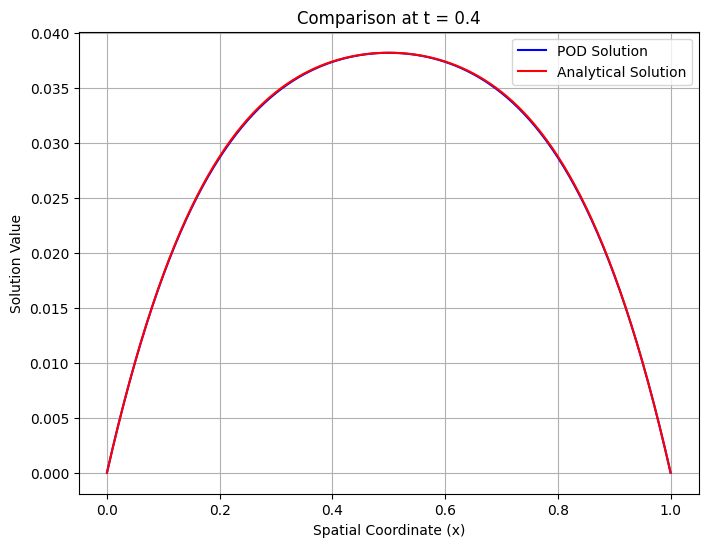

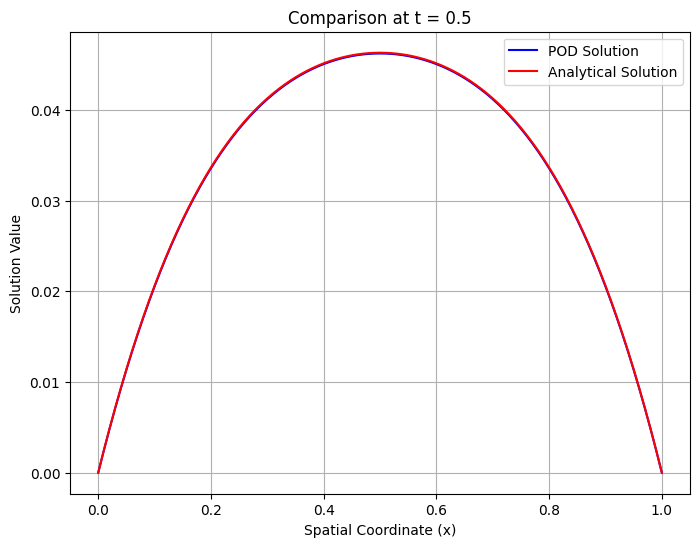

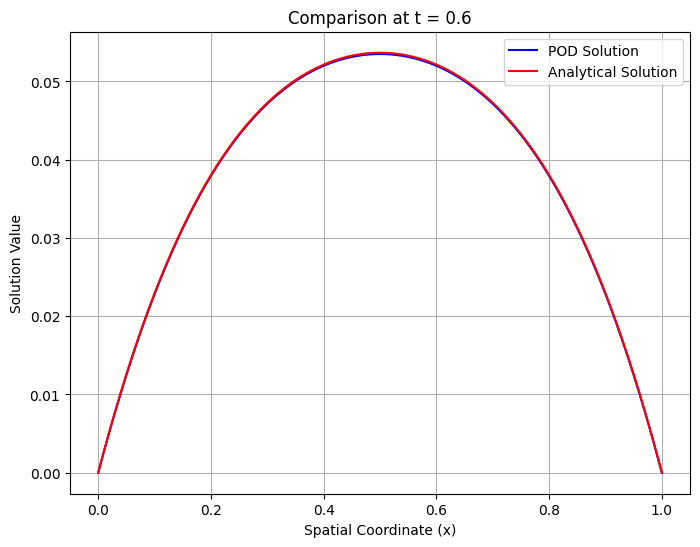

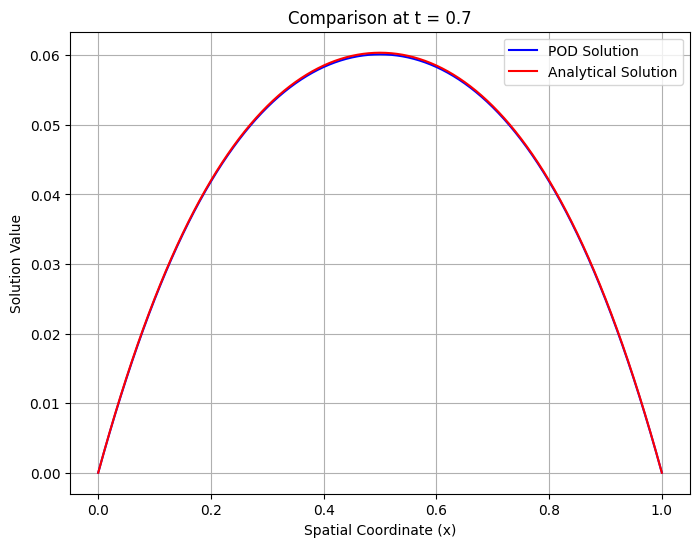

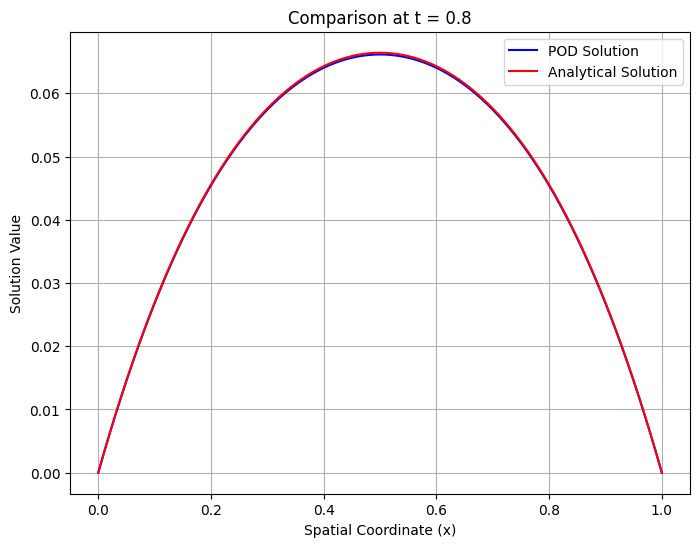

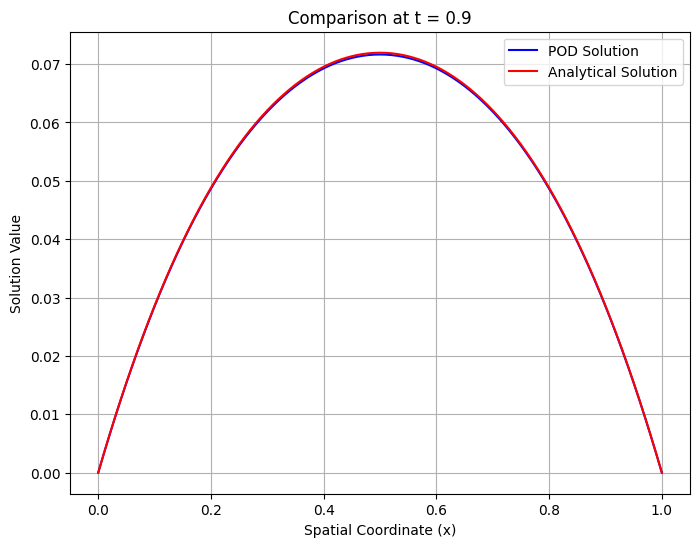

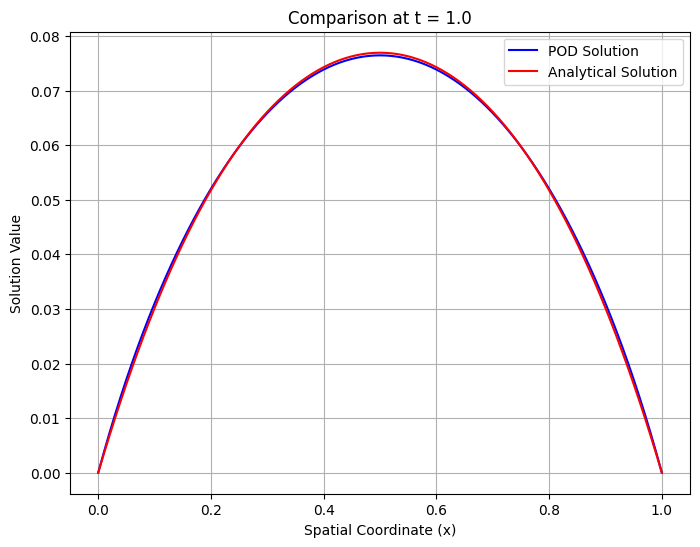

In [ ]:
## Define space and time discretization
Nx = 101
Nt = 101

t = np.linspace(0,0.1,Nt)

x = np.linspace(0,1,Nx)

## Define seperated source terms of f, i.e. f0 and f1
f0 = np.ones(Nx)
f1 = np.ones(Nt)

## Call HT1D_PGD_XT and store the PGD solution

k=1
rho = 1
cp = 1

Max_terms = 5
Max_fp_iter = 5

epsilon = 1e-6
epsilon_tilde = 1e-6

Alpha, B0s, B1s = HT1D_PGD_XT(x,t,k,rho,cp,Max_terms,Max_fp_iter,epsilon,epsilon_tilde,f0,f1)

## Expand the PGD solution and compare with solution from ExactSolution

## TO DO. Steps briefly described below
## Expand the PGD solution and compare with solution from ExactSolution

U = ExactSolution(x, t, Max_terms)
PGD_Solution = B0s@np.diag(Alpha)@B1s.T

Norm2Err = np.linalg.norm(np.linalg.norm(PGD_Solution-U))

NormInfErr = np.abs(PGD_Solution-U).max()
Error = abs(PGD_Solution - U)
Relative_Error = abs(PGD_Solution - U)/abs(PGD_Solution)

time_step = 10

for time in range(10, 101, time_step):
    pgd = PGD_Solution[:, time]
    analytical = U[:, time]

    plt.figure(figsize=(8, 6))
    plt.plot(x, pgd, label="POD Solution", color='b')
    plt.plot(x, analytical, label="Analytical Solution", color='r')
    plt.xlabel('Spatial Coordinate (x)')
    plt.ylabel('Solution Value')
    timez = time / (Nt - 1)
    plt.title(f"Comparison at t = {timez}")
    plt.legend()
    plt.grid(True)
    plt.show()



### Surface Plot of Absolute Error w.r.t parameters x and t

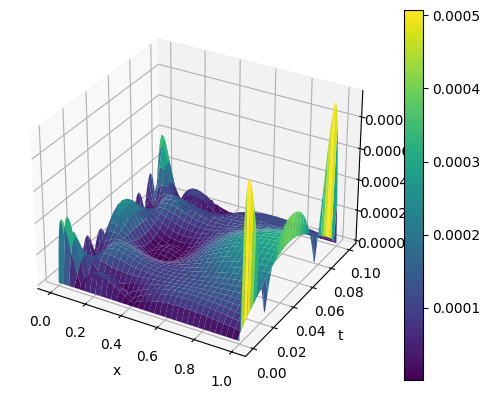

Computed  5 PGD terms
Norm2 and Max error : 1.53e-02 , 9.44e-04


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

X, T = np.meshgrid(x, t)

# Create the 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, Error, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Abs.Error')
fig.savefig("ERROR.png")
fig.colorbar(surf)

plt.show()

print(f"Computed {Alpha.size:2d} PGD terms")
print(f"Norm2 and Max error : {Norm2Err:0.2e} , {NormInfErr:0.2e}")


### Contours of PGD Solution w.r.t x and t

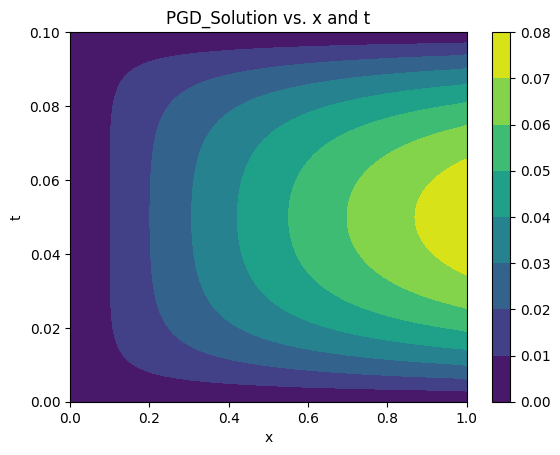

In [ ]:

plt.figure()
plt.contourf(X, T, PGD_Solution, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('PGD_Solution vs. x and t')
plt.show()

### Contours of Analytical Solution w.r.t x and t

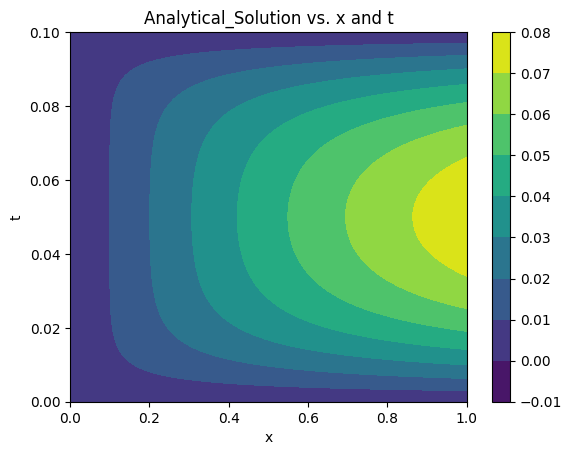

In [ ]:

plt.figure()
plt.contourf(X, T, U, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical_Solution vs. x and t')
plt.show()

### Surface Plot of Relative Error w.r.t parameters x and t

/shared-libs/python3.9/py/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


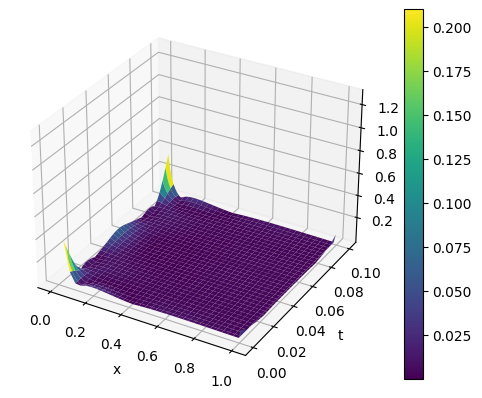

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

X, T = np.meshgrid(x, t)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T,Relative_Error, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Relative_Error')

fig.colorbar(surf)
fig.savefig("Rel_ERROR.png")

plt.show()


### Parametric Analysis

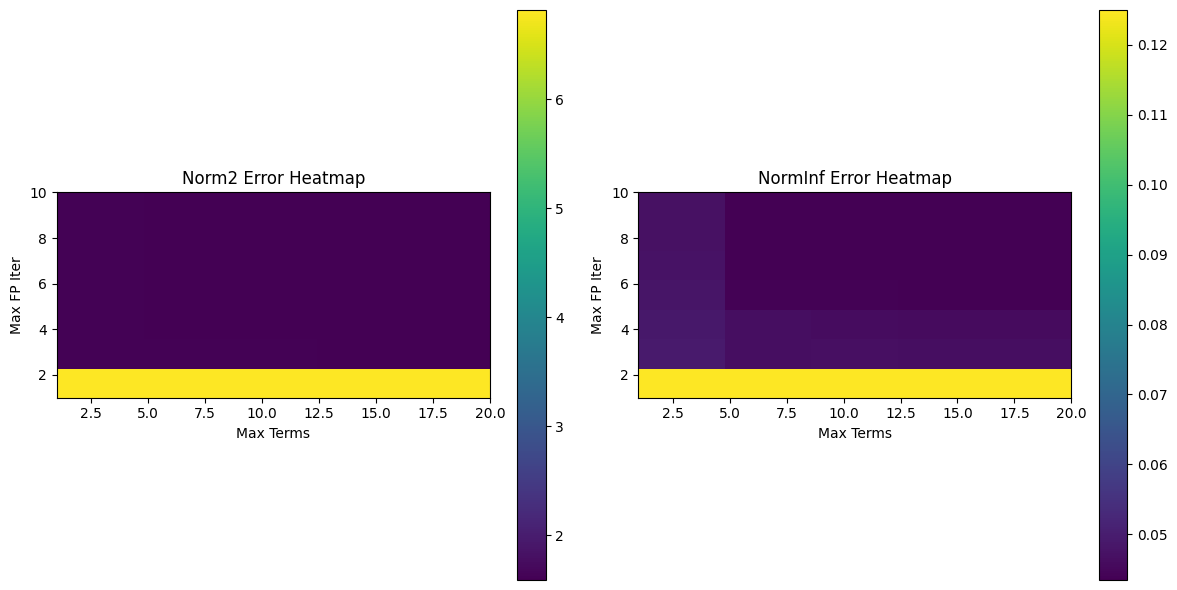

In [ ]:
import matplotlib.pyplot as plt

# Range of values for each parameter
max_terms_values = [1, 2, 3, 5, 10, 15, 20] 
max_fp_iter_values = [1, 2, 3, 5, 10]  
epsilon_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] 
epsilon_tilde_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  

norm2_err_grid = np.zeros((len(max_terms_values), len(max_fp_iter_values), len(epsilon_values), len(epsilon_tilde_values)))
norm_inf_err_grid = np.zeros((len(max_terms_values), len(max_fp_iter_values), len(epsilon_values), len(epsilon_tilde_values)))

for i, max_terms in enumerate(max_terms_values):
    for j, max_fp_iter in enumerate(max_fp_iter_values):
        for k, epsilon in enumerate(epsilon_values):
            for l, epsilon_tilde in enumerate(epsilon_tilde_values):
                
                Alpha, B0s, B1s = HT1D_PGD_XT(x, t, k, rho, cp, max_terms, max_fp_iter, epsilon, epsilon_tilde, f0, f1)
                U = ExactSolution(x, t, max_terms)
                PGD_Solution = B0s @ np.diag(Alpha) @ B1s.T

                
                norm2_err = np.linalg.norm(np.linalg.norm(PGD_Solution - U))
                norm_inf_err = np.abs(PGD_Solution - U).max()

                
                norm2_err_grid[i, j, k, l] = norm2_err
                norm_inf_err_grid[i, j, k, l] = norm_inf_err

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
heatmap_data = norm2_err_grid.mean(axis=(2, 3))  # Average over epsilon and epsilon_tilde
plt.imshow(heatmap_data, cmap='viridis', origin='lower',
           extent=[min(max_terms_values), max(max_terms_values), min(max_fp_iter_values), max(max_fp_iter_values)])
plt.colorbar()
plt.title('Norm2 Error Heatmap')
plt.xlabel('Max Terms')
plt.ylabel('Max FP Iter')

plt.subplot(1, 2, 2)
heatmap_data = norm_inf_err_grid.mean(axis=(2, 3))  # Average over epsilon and epsilon_tilde
plt.imshow(heatmap_data, cmap='viridis', origin='lower',
           extent=[min(max_terms_values), max(max_terms_values), min(max_fp_iter_values), max(max_fp_iter_values)])
plt.colorbar()
plt.title('NormInf Error Heatmap')
plt.xlabel('Max Terms')
plt.ylabel('Max FP Iter')

plt.tight_layout()
plt.show()




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c8132513-adf6-42e0-a2e8-0b78be613e52' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>